In [1]:
%%capture
%pylab inline --no-import-all
from QuantLib import *
import matplotlib.pyplot as plt
import math
import ql_utils as utils

In [2]:
utils.set_default_plot_size()

In [3]:
today = Date(18, June, 2018)
Settings.instance().evaluationDate = today

In [4]:
helpers = [ DepositRateHelper(QuoteHandle(SimpleQuote(rate/100)), Period(1,Days), fixingDays, 
                              TARGET(), Following, False, Actual360()) 
           for rate, fixingDays in [(-0.365, 0), (-0.365, 1), (-0.365, 2)] ]

In [5]:
eonia = Eonia()

In [6]:
helpers += [ OISRateHelper(2, Period(*tenor), QuoteHandle(SimpleQuote(rate/100)), eonia)
            for rate, tenor in [(-0.36, (1,Weeks)), (-0.35, (2,Weeks)),
                                (-0.35, (3,Weeks)), (-0.35, (1,Months)),
                                (-0.35, (2,Months)), (-0.357, (3,Months)),
                                (-0.3489, (4,Months)), (-0.35, (5,Months)),
                                (-0.3554, (6,Months)), (-0.353, (12,Months)),
                                (-0.33805, (18,Months)), (-0.3012, (2,Years)),
                                (-0.2385, (30,Months)),
                                (-0.189, (3,Years)), (-0.0575, (4,Years)),
                                (0.076, (5,Years)), (0.208, (6,Years)),
                                (0.336, (7,Years)), (0.458, (8,Years)),
                                (0.57175, (9,Years)), (0.674, (10,Years)),
                                (0.769, (11,Years)), (0.8543, (12,Years)),
                                (1.053, (15,Years)), (1.2395, (20,Years)),
                                (1.3137, (25,Years)), (1.3425, (30,Years))] ]

In [7]:
eonia_curve_c = PiecewiseLogCubicDiscount(0, TARGET(), helpers, Actual365Fixed())
eonia_curve_c.enableExtrapolation()

### First checks
2 Year and 30 Year

In [8]:
today = eonia_curve_c.referenceDate()
end = today + Period(2,Years)
dates = [ Date(serial) for serial in range(today.serialNumber(), end.serialNumber()+1) ]
rates_c = [ eonia_curve_c.forwardRate(d, TARGET().advance(d,1,Days), Actual360(), Simple).rate() for d in dates ]

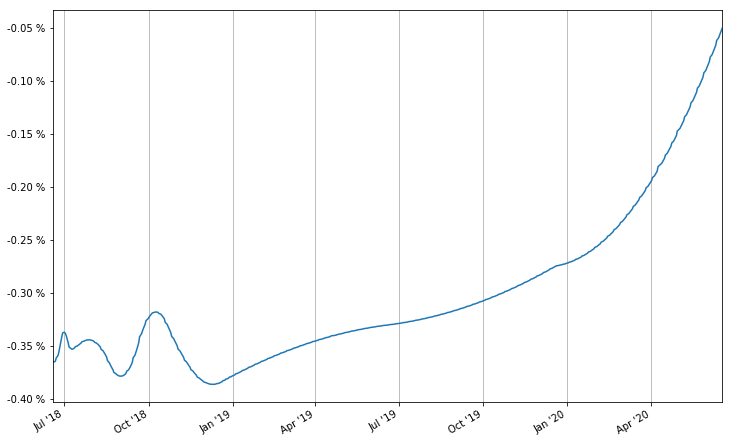

In [9]:
utils.plot_curve(plt, dates, [(rates_c,'-')])

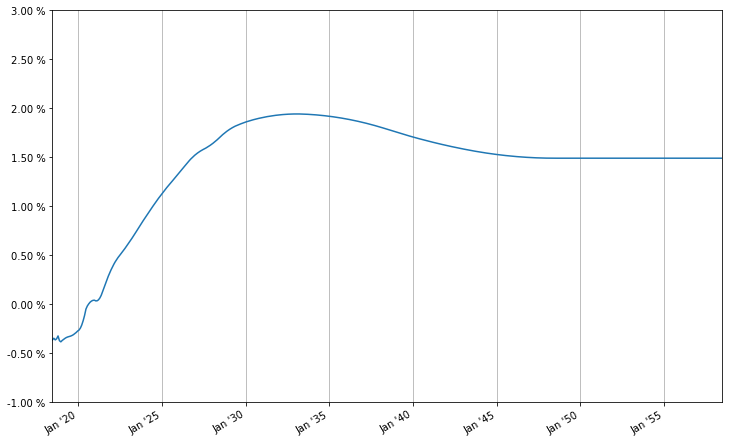

In [10]:
dates = [ today+Period(i,Months) for i in range(0, 12*40+1) ]
rates = [ eonia_curve_c.forwardRate(d, TARGET().advance(d,1,Days), Actual360(), Simple).rate() for d in dates ]

utils.plot_curve(plt, dates, [(rates,'-')], ymin=-0.01, ymax=0.03)

IRS

In [11]:
calculation_date = Date(19, 6, 2018)
Settings.instance().evaluationDate = calculation_date

OIS dicount curve - let's see

In [12]:
discount_curve = YieldTermStructureHandle(eonia_curve_c)

rest of the information - flat and the same as first IRS

In [13]:

libor_rate = 0.02
day_count = Actual365Fixed()
libor_curve = YieldTermStructureHandle(FlatForward(calculation_date, libor_rate, day_count, Continuous, Semiannual))
#libor3M_index = Euribor3M(libor_curve)
libor3M_index = USDLibor(Period(3, Months), libor_curve)

In [14]:
calendar = UnitedStates()
settle_date = calendar.advance(calculation_date, 5, Days)
maturity_date = calendar.advance(settle_date, 10, Years)
fixed_leg_tenor = Period(6, Months)
fixed_schedule = Schedule(settle_date, maturity_date, fixed_leg_tenor, calendar, ModifiedFollowing, ModifiedFollowing,
DateGeneration.Forward, False)
float_leg_tenor = Period(3, Months)
float_schedule = Schedule (settle_date, maturity_date, float_leg_tenor, calendar,
ModifiedFollowing, ModifiedFollowing, DateGeneration.Forward, False)

In [15]:
notional = 10000000
fixed_rate = 0.01
fixed_leg_daycount = Actual360()
float_spread = 0.002
float_leg_daycount = Actual360()
ir_swap = VanillaSwap(VanillaSwap.Payer, notional, fixed_schedule,fixed_rate, fixed_leg_daycount, float_schedule,
libor3M_index, float_spread, float_leg_daycount )

In [16]:
swap_engine = DiscountingSwapEngine(discount_curve)
ir_swap.setPricingEngine(swap_engine)

In [17]:
for i, cf in enumerate(ir_swap.leg(0)):
    print("%2d %-20s %10.2f"%(i+1, cf.date(), cf.amount()))

 1 December 26th, 2018    50833.33
 2 June 26th, 2019        50555.56
 3 December 26th, 2019    50833.33
 4 June 26th, 2020        50833.33
 5 December 28th, 2020    51388.89
 6 June 28th, 2021        50555.56
 7 December 27th, 2021    50555.56
 8 June 27th, 2022        50555.56
 9 December 27th, 2022    50833.33
10 June 26th, 2023        50277.78
11 December 26th, 2023    50833.33
12 June 26th, 2024        50833.33
13 December 26th, 2024    50833.33
14 June 26th, 2025        50555.56
15 December 26th, 2025    50833.33
16 June 26th, 2026        50555.56
17 December 28th, 2026    51388.89
18 June 28th, 2027        50555.56
19 December 27th, 2027    50555.56
20 June 26th, 2028        50555.56


In [18]:
for i, cf in enumerate(ir_swap.leg(1)):
    print("%2d %-20s %10.2f"%(i+1, cf.date(), cf.amount()))

 1 September 26th, 2018   55649.35
 2 December 26th, 2018    55044.46
 3 March 26th, 2019       54435.51
 4 June 26th, 2019        55649.35
 5 September 26th, 2019   55649.35
 6 December 26th, 2019    55044.46
 7 March 26th, 2020       55041.72
 8 June 26th, 2020        55649.35
 9 September 28th, 2020   56861.95
10 December 28th, 2020    55044.46
11 March 26th, 2021       53223.18
12 June 28th, 2021        56861.95
13 September 27th, 2021   55043.09
14 December 27th, 2021    55045.83
15 March 28th, 2022       55040.35
16 June 27th, 2022        55043.09
17 September 26th, 2022   55043.09
18 December 27th, 2022    55650.73
19 March 27th, 2023       54435.51
20 June 26th, 2023        55043.09
21 September 26th, 2023   55649.35
22 December 26th, 2023    55044.46
23 March 26th, 2024       55041.72
24 June 26th, 2024        55649.35
25 September 26th, 2024   55649.35
26 December 26th, 2024    55044.46
27 March 26th, 2025       54435.51
28 June 26th, 2025        55649.35
29 September 26th, 2

In [19]:
print("%-20s: %20.3f" % ("Net Present Value", ir_swap.NPV()))
print("%-20s: %20.3f" % ("Fair Spread", ir_swap.fairSpread()))
print("%-20s: %20.3f" % ("Fair Rate", ir_swap.fairRate()))
print("%-20s: %20.3f" % ("Fixed Leg BPS", ir_swap.fixedLegBPS()))
print("%-20s: %20.3f" % ("Floating Leg BPS", ir_swap.floatingLegBPS()))


Net Present Value   :          1177586.663
Fair Spread         :               -0.010
Fair Rate           :                0.022
Fixed Leg BPS       :            -9983.937
Floating Leg BPS    :             9992.804
